# Day 1: Decision Trees for Trading

## 🎯 Learning Objectives
- Understand decision tree fundamentals
- Learn splitting criteria (Gini, Entropy, MSE)
- Apply decision trees to trading signals
- Interpret tree rules for trading

---

## 📚 Theory: Decision Trees

### How Decision Trees Work
Recursive binary partitioning:
1. Find best split (feature + threshold)
2. Split data into two nodes
3. Repeat until stopping criteria

### Splitting Criteria

**Classification:**
- Gini Impurity: $G = 1 - \sum_{k} p_k^2$
- Entropy: $H = -\sum_{k} p_k \log_2 p_k$

**Regression:**
- MSE: $\frac{1}{n}\sum_{i}(y_i - \bar{y})^2$

### Information Gain
$$IG = H(parent) - \sum_{j} \frac{n_j}{n} H(child_j)$$

### Pruning
- **Pre-pruning**: max_depth, min_samples_split
- **Post-pruning**: Cost-complexity pruning (ccp_alpha)

### Pros & Cons

| Pros | Cons |
|------|------|
| Interpretable rules | High variance (overfitting) |
| Handles non-linearity | Unstable (small changes → different tree) |
| No scaling needed | Axis-parallel splits only |
| Feature importance | Prone to bias toward features with more levels |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             mean_squared_error, r2_score)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days for {ticker}")

📥 Downloading data...
✅ Data: 1254 days for AAPL


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum features
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()

# Volume
df['volume_ratio'] = volume / volume.rolling(20).mean()

# Moving averages
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Target: Binary classification
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Dataset: {len(df)} samples")

📊 Dataset: 1204 samples


In [3]:
# Prepare data
feature_cols = ['momentum_1', 'momentum_5', 'momentum_10', 'momentum_20',
                'volatility_10', 'volatility_20', 'volume_ratio',
                'ma_5_20', 'ma_20_50', 'rsi']

X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 963, Test: 241


In [4]:
# Train Decision Trees with different depths
depths = [2, 3, 5, 10, None]  # None = unlimited

print("\n" + "="*70)
print("DECISION TREE: EFFECT OF DEPTH")
print("="*70)

depth_results = []
trees = {}

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    trees[depth] = dt
    
    train_acc = accuracy_score(y_train, dt.predict(X_train))
    test_acc = accuracy_score(y_test, dt.predict(X_test))
    
    depth_results.append({
        'Depth': str(depth) if depth else 'Unlimited',
        'Nodes': dt.tree_.node_count,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Overfit Gap': train_acc - test_acc
    })

depth_df = pd.DataFrame(depth_results)
print(depth_df.to_string(index=False))


DECISION TREE: EFFECT OF DEPTH
    Depth  Nodes  Train Acc  Test Acc  Overfit Gap
        2      7   0.544133  0.535270     0.008863
        3     11   0.570093  0.535270     0.034824
        5     35   0.624091  0.481328     0.142764
       10    199   0.800623  0.522822     0.277801
Unlimited    421   1.000000  0.514523     0.485477


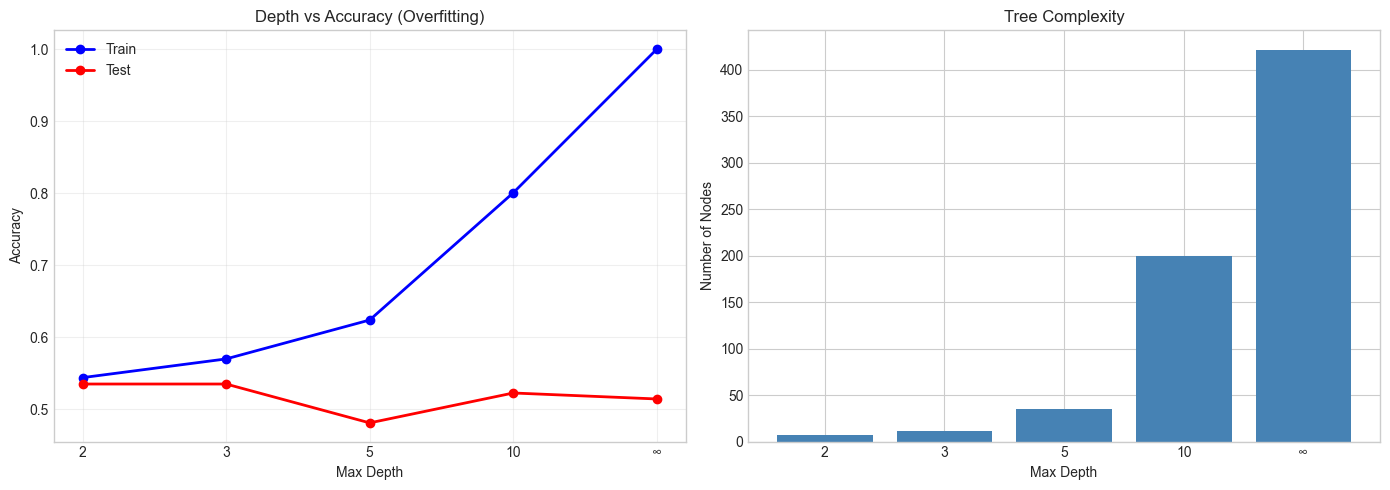

In [5]:
# Plot depth vs performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_labels = [str(d) if d else '∞' for d in depths]

# Accuracy
axes[0].plot(x_labels, depth_df['Train Acc'], 'b-o', label='Train', linewidth=2)
axes[0].plot(x_labels, depth_df['Test Acc'], 'r-o', label='Test', linewidth=2)
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Depth vs Accuracy (Overfitting)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Nodes
axes[1].bar(x_labels, depth_df['Nodes'], color='steelblue')
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('Number of Nodes')
axes[1].set_title('Tree Complexity')

plt.tight_layout()
plt.show()

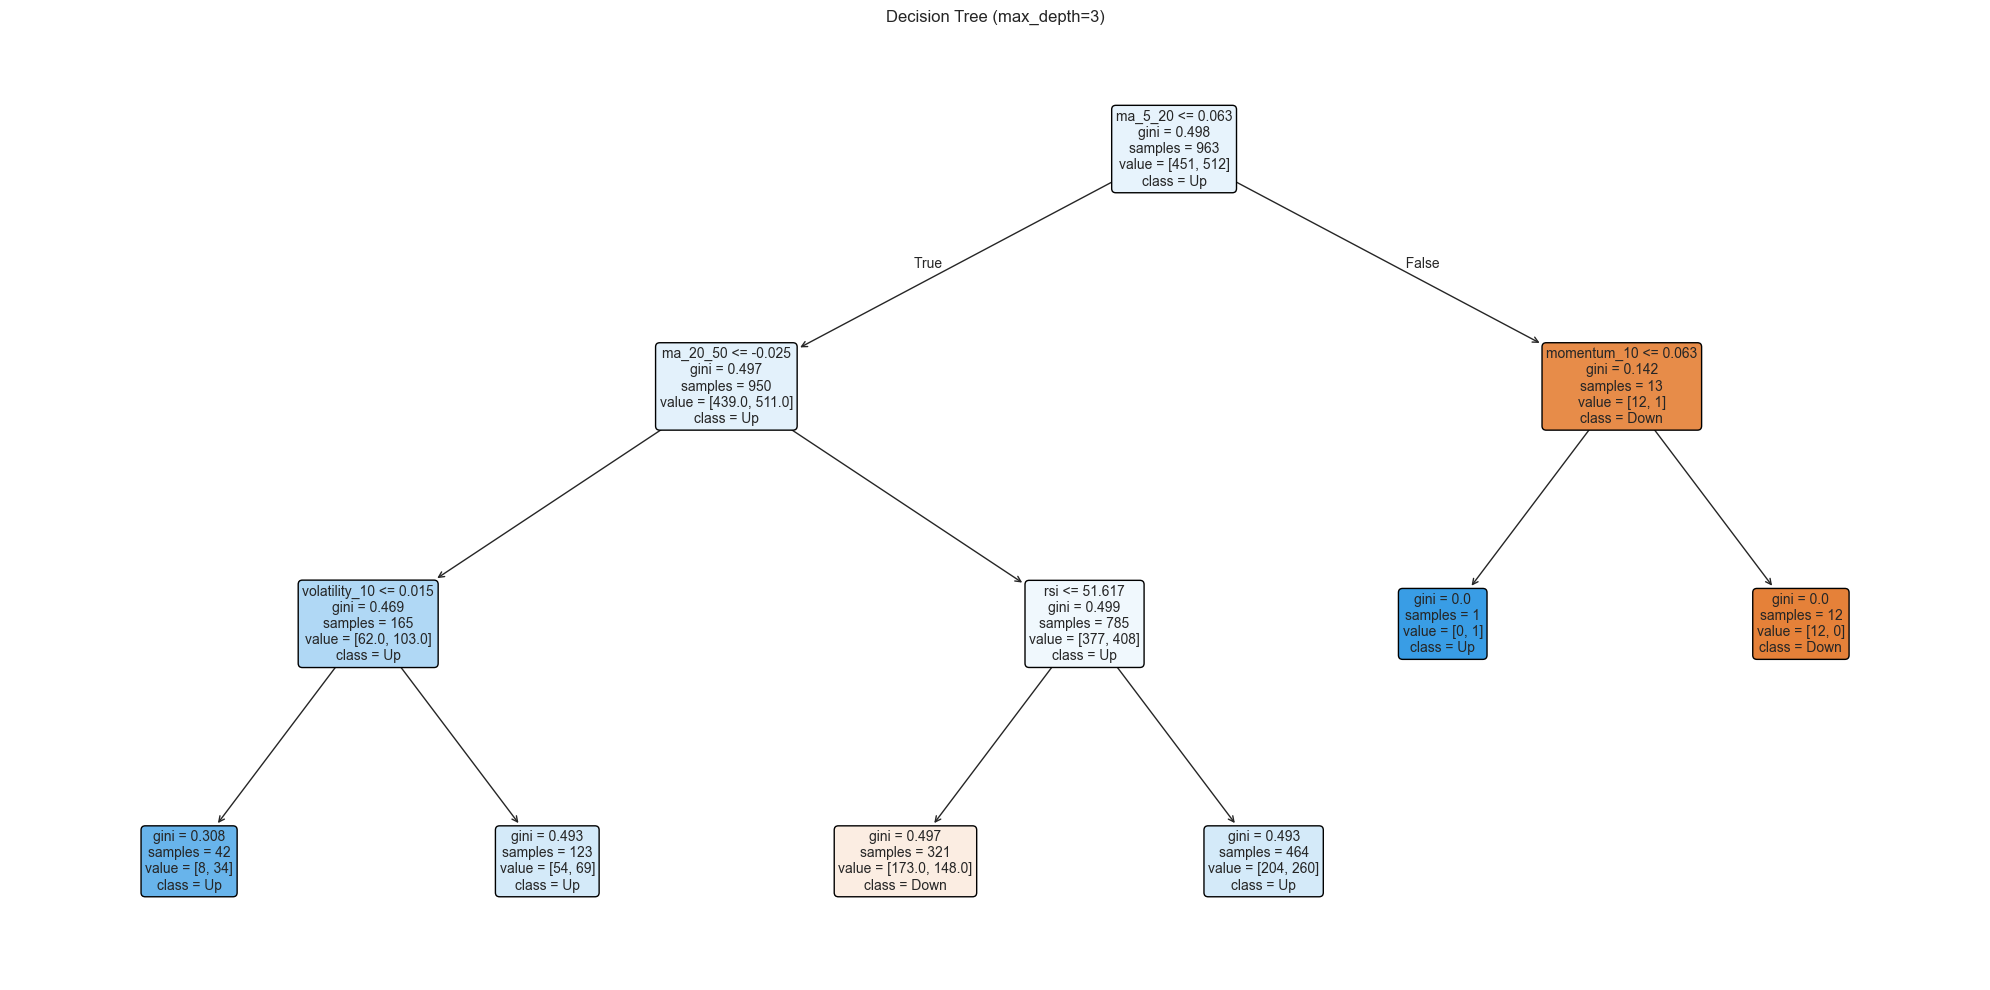

In [6]:
# Optimal tree (shallow for interpretability)
optimal_depth = 3
dt_optimal = trees[optimal_depth]

# Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(dt_optimal, feature_names=feature_cols, class_names=['Down', 'Up'],
          filled=True, rounded=True, fontsize=10)
plt.title(f'Decision Tree (max_depth={optimal_depth})')
plt.tight_layout()
plt.show()

In [7]:
# Export tree rules
tree_rules = export_text(dt_optimal, feature_names=feature_cols)
print("\n" + "="*60)
print("DECISION TREE RULES")
print("="*60)
print(tree_rules)


DECISION TREE RULES
|--- ma_5_20 <= 0.06
|   |--- ma_20_50 <= -0.02
|   |   |--- volatility_10 <= 0.02
|   |   |   |--- class: 1
|   |   |--- volatility_10 >  0.02
|   |   |   |--- class: 1
|   |--- ma_20_50 >  -0.02
|   |   |--- rsi <= 51.62
|   |   |   |--- class: 0
|   |   |--- rsi >  51.62
|   |   |   |--- class: 1
|--- ma_5_20 >  0.06
|   |--- momentum_10 <= 0.06
|   |   |--- class: 1
|   |--- momentum_10 >  0.06
|   |   |--- class: 0



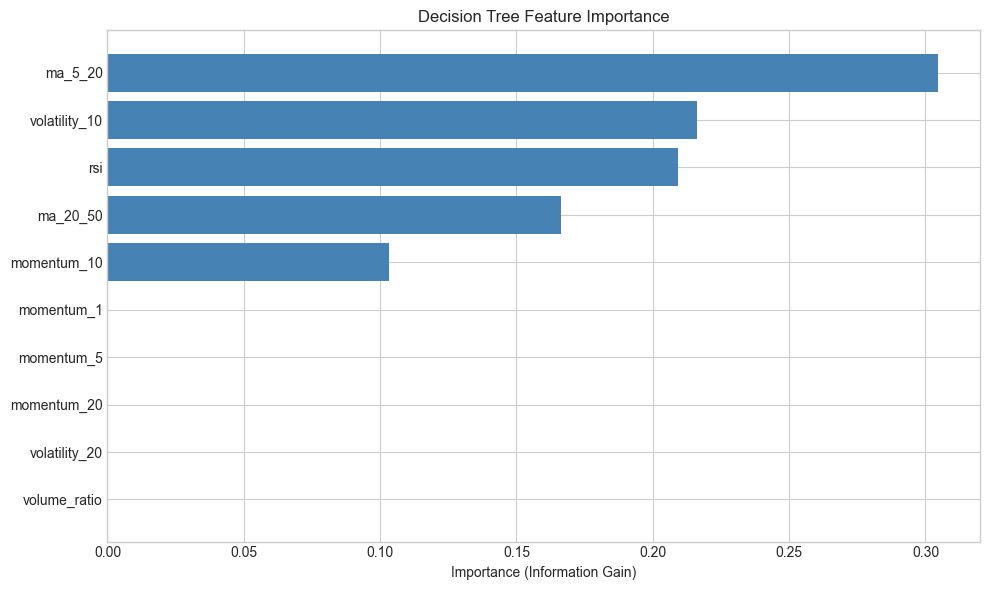

In [8]:
# Feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': dt_optimal.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='steelblue')
plt.xlabel('Importance (Information Gain)')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
# Cross-validation for hyperparameter tuning
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20]
}

tscv = TimeSeriesSplit(n_splits=5)
dt_cv = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt_cv, param_grid, cv=tscv, scoring='f1')
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

dt_best = grid_search.best_estimator_


HYPERPARAMETER TUNING
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV Score: 0.5800


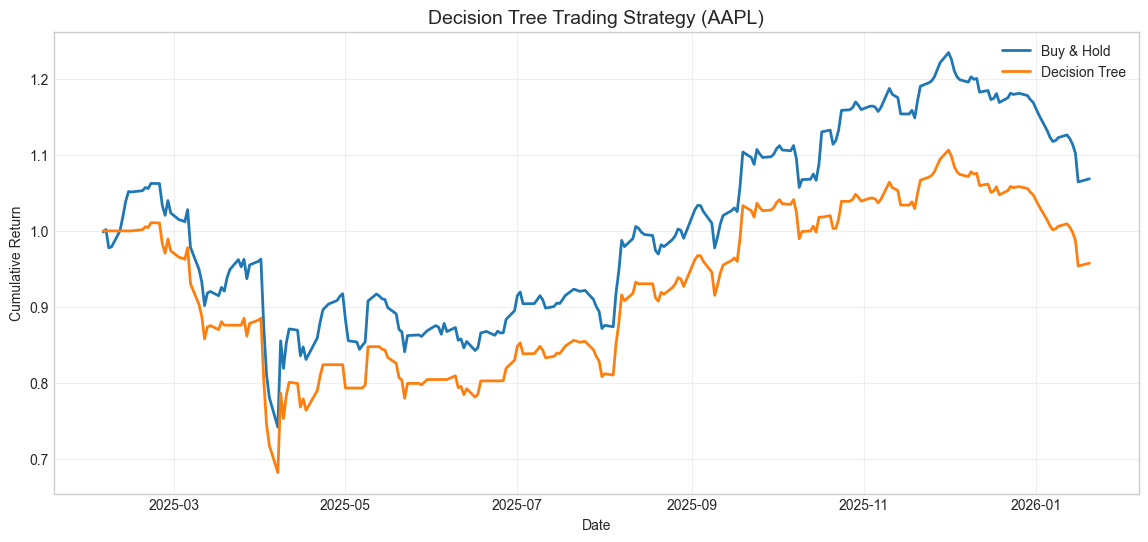

In [10]:
# Trading Strategy Backtest
y_pred = dt_best.predict(X_test)
y_proba = dt_best.predict_proba(X_test)[:, 1]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Strategy: Long when predicted up
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()
backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='Decision Tree', linewidth=2)
plt.title(f'Decision Tree Trading Strategy ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

total_bh, sharpe_bh, mdd_bh = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
total_st, sharpe_st, mdd_st = calc_metrics(backtest['strategy_return'], backtest['strategy_cum'])

print(f"\n{'Metric':<20} {'Buy & Hold':>15} {'Decision Tree':>15}")
print("-" * 55)
print(f"{'Total Return':<20} {total_bh:>15.2%} {total_st:>15.2%}")
print(f"{'Sharpe Ratio':<20} {sharpe_bh:>15.2f} {sharpe_st:>15.2f}")
print(f"{'Max Drawdown':<20} {mdd_bh:>15.2%} {mdd_st:>15.2%}")
print(f"{'Accuracy':<20} {'-':>15} {accuracy_score(y_test, y_pred):>15.2%}")


STRATEGY PERFORMANCE

Metric                    Buy & Hold   Decision Tree
-------------------------------------------------------
Total Return                   6.86%          -4.26%
Sharpe Ratio                    0.22           -0.16
Max Drawdown                 -30.22%         -32.56%
Accuracy                           -          48.96%


In [12]:
# Next day prediction
latest = X.iloc[-1:]
pred = dt_best.predict(latest)[0]
proba = dt_best.predict_proba(latest)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Probability (Up): {proba[1]:.2%}")

# Show the path through the tree
print(f"\nKey Features:")
for feat in importance.head(3)['Feature']:
    print(f"  {feat}: {latest[feat].values[0]:.4f}")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20

Prediction: 📈 UP
Probability (Up): 52.04%

Key Features:
  ma_5_20: -0.0336
  volatility_10: 0.0115
  rsi: 6.4671


---

## 🏢 Real-World Applications

| Company | Decision Tree Use Case |
|---------|----------------------|
| Banks | Credit scoring rules |
| Asset Managers | Factor screening |
| Hedge Funds | Feature interaction discovery |
| Risk Teams | Explainable risk limits |

### Key Interview Points
1. **Why trees overfit?** - They can grow to perfectly fit training data
2. **Gini vs Entropy?** - Similar results; Gini faster to compute
3. **When to use trees?** - Interpretability needed, non-linear relationships
4. **Main weakness?** - High variance, unstable with small data changes

---
## 📅 Tomorrow: Random Forest